<a href="https://colab.research.google.com/github/zzzzihy/zzzzihy/blob/main/0311_gradientboosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

In [8]:
# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
matplotlib.rc("font",family = "NanumGothic")
matplotlib.rc("axes", unicode_minus = False)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_raw = pd.read_csv("/content/drive/MyDrive/BigData/final_scale.csv")
df_raw.head()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn,purpose
0,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간,선체구조용(조선용)
1,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간,선체구조용(조선용)
2,0,NV-E36-TM,영국,T,33,3600,19200,적용,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간,선체구조용(조선용)
3,0,NV-E36-TM,영국,T,33,3600,19200,적용,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간,선체구조용(조선용)
4,0,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간,선체구조용(조선용)


In [4]:
df_raw['descaling_count'] = df_raw['descaling_count'].apply(lambda x: 'odd' if x % 2 != 0 else str(x))  # 홀수는 'odd', 짝수는 문자열로 범주화

In [5]:
df_raw_x = df_raw.drop('scale', axis=1)
df_raw_x_1 = df_raw.drop(["scale", "spec_long"], axis=1)
df_raw_x_2 = df_raw[['steel_kind', 'day_yn', 'rolling_method']]  # 범주가 2개인 자료는 따로 dummy화
df_raw_y = df_raw['scale']

In [6]:

# 범주형 변수 선택 : select_dtypes="object"
df_raw_x_char_1 = df_raw_x_1.select_dtypes(include = "object")
df_raw_x_char_2 = df_raw_x_2.select_dtypes(include = "object")
df_raw_x_char = pd.concat([df_raw_x_char_1, df_raw_x_char_2], axis=1)

# get_dummies: 범주형 변수에 대한 더미변환
df_x_dummy_1 = pd.get_dummies(df_raw_x_char_1)
df_x_dummy_2 = pd.get_dummies(df_raw_x_char_2, drop_first=True) # 범주가 2개인 자료는 따로 dummy화
df_x_dummy = pd.concat([df_x_dummy_1, df_x_dummy_2], axis=1)


# 연속형 변수 선택 : select_dtypes="object" 제외
df_raw_x_num = df_raw_x.select_dtypes(exclude = "object")

# 변수명 저장
v_feature_names = df_raw_x_num.columns

# StandardScaler 적용
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_raw_x_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)

# 원래 연속형(df_raw_x_num) + dummy된 범주형(df_x_dummy)
df_x_raw_dummy = df_raw_x_num.join(df_x_dummy)
display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:",df_x_raw_dummy.head(3))

# scale된 연속형(df_x_scaled)+ dummy된 범주형(df_x_dummy)
df_x_scale_dummy = df_x_scaled.join(df_x_dummy)
display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:",df_x_scale_dummy.head(3))

# scale된 연속형(df_x_scaled) + 원래 범주형(df_raw_x_char)
df_x_scale_raw = df_x_scaled.join(df_raw_x_char)
display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_x_scale_raw.head(3))

'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,descaling_count_odd,day_yn_야간,day_yn_주간,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
0,32,3700,15100,1,1,1144,116,1133,59,259,...,0,0,1,0,1,0,0,1,1,1
1,32,3700,15100,1,2,1144,122,1135,53,238,...,0,0,1,0,1,0,0,1,1,1
2,33,3600,19200,2,1,1129,116,1121,55,258,...,0,0,1,0,1,0,0,1,1,1


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,descaling_count_odd,day_yn_야간,day_yn_주간,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
0,0.298839,1.765880,-1.561273,-1.227015,-0.982207,-0.623951,1.13104,-1.034421,-0.615879,0.534990,...,0,0,1,0,1,0,0,1,1,1
1,0.298839,1.765880,-1.561273,-1.227015,1.018115,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,...,0,0,1,0,1,0,0,1,1,1
2,0.354957,1.562785,-1.265674,-0.003875,-0.982207,-1.333010,1.13104,-1.728433,-0.809920,0.508684,...,0,0,1,0,1,0,0,1,1,1


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,spec_country,steel_kind,hsb,rolling_method,descaling_count,day_yn,purpose,steel_kind,day_yn,rolling_method
0,0.298839,1.765880,-1.561273,-1.227015,-0.982207,-0.623951,1.13104,-1.034421,-0.615879,0.534990,...,미국,T,적용,TMCP(온도제어),8,주간,선체구조용(조선용),T,주간,TMCP(온도제어)
1,0.298839,1.765880,-1.561273,-1.227015,1.018115,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,...,미국,T,적용,TMCP(온도제어),8,주간,선체구조용(조선용),T,주간,TMCP(온도제어)
2,0.354957,1.562785,-1.265674,-0.003875,-0.982207,-1.333010,1.13104,-1.728433,-0.809920,0.508684,...,영국,T,적용,TMCP(온도제어),8,주간,선체구조용(조선용),T,주간,TMCP(온도제어)


In [7]:
## train_test_split
# 원래 연속형+ Dummied 범주형...DT/RF/GB 용:df_x_raw_dummy
df_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_raw_dummy, df_raw_y
                                    , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"])

display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:", df_train_x_rd.head())

# 기계학습용 데이터(Scaled 연속형+ Dummied 범주형) 분할:df_x_scale_dummy
df_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_scale_dummy, df_raw_y
                                    , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"])

display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:", df_train_x_sd.head())

# 회귀분석용(표준화 회귀계수) 데이터(Scaled 연속형+ 원래 범주형) 분할:df_x_scale_raw
df_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_scale_raw, df_raw_y
                                    , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"])

display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_train_x_reg.head())

'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,descaling_count_odd,day_yn_야간,day_yn_주간,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
86,71,2700,11000,3,1,1142,109,1130,73,266,...,0,1,0,0,1,0,0,1,0,1
580,74,2700,11000,2,1,1119,70,1118,130,291,...,0,0,1,0,1,0,0,1,1,1
372,19,3600,41000,3,1,1186,73,1172,53,232,...,0,1,0,0,1,0,0,0,0,0
882,20,3100,47000,3,1,1177,72,1164,60,190,...,0,0,1,0,1,0,0,0,1,0
600,13,3400,53700,2,2,1147,73,1129,107,246,...,0,0,1,0,1,0,0,0,1,0


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,descaling_count_odd,day_yn_야간,day_yn_주간,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
373,-0.430688,0.953498,-0.580751,-1.227015,1.018115,1.125059,-0.765039,1.047613,-0.082268,-1.253753,...,0,1,0,0,1,0,0,0,0,0
425,-0.655158,0.953498,0.212317,1.219266,-0.982207,1.834118,-0.802961,1.741624,-1.003961,-1.753549,...,0,0,1,0,1,0,0,0,1,0
287,-0.655158,-0.265075,0.493496,-1.227015,1.018115,-1.238469,-0.954647,-0.745250,-1.198002,-1.937684,...,0,0,1,0,1,0,0,0,1,0
102,2.768009,-0.671266,-1.986646,-1.227015,-0.982207,-1.191198,-0.272058,-1.381427,0.548365,-0.175247,...,0,1,0,0,1,0,0,1,0,1
198,-0.374571,-0.468171,0.637691,-1.227015,-0.982207,0.368730,-0.309980,0.700607,-0.033757,0.087804,...,0,0,1,0,0,1,0,0,1,0


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,spec_country,steel_kind,hsb,rolling_method,descaling_count,day_yn,purpose,steel_kind,day_yn,rolling_method
628,-0.767393,0.750403,0.428609,1.219266,-0.982207,0.132378,2.534139,-0.745250,0.451344,2.192207,...,영국,C,적용,CR(제어압연),10,야간,선체구조용(조선용),C,야간,CR(제어압연)
328,-0.093983,0.141116,0.262785,1.219266,1.018115,-0.623951,-0.878804,0.469270,-0.664390,-0.464602,...,미국,C,적용,CR(제어압연),8,주간,선체구조용(조선용),C,주간,CR(제어압연)
427,-0.655158,0.953498,0.226737,-1.227015,-0.982207,1.975930,-0.499588,1.857293,-0.809920,-0.753957,...,영국,C,적용,CR(제어압연),10,주간,선체구조용(조선용),C,주간,CR(제어압연)
345,-0.374571,0.953498,-0.573542,-1.227015,-0.982207,0.226919,-0.537509,0.469270,-0.761410,-0.622432,...,프랑스,C,적용,CR(제어압연),10,야간,선체구조용(조선용),C,야간,CR(제어압연)
185,0.467191,-1.686744,-0.494235,-0.003875,-0.982207,0.226919,-0.234137,0.642773,-1.198002,-0.832873,...,한국,C,적용,CR(제어압연),8,주간,용접구조용,C,주간,CR(제어압연)


# 그래디언트 부스팅 모델 생성

In [9]:
# 그래디언트 부스팅 모델 생성: GradientBoostingClassifier
gb_uncust = GradientBoostingClassifier(random_state=1234)
gb_uncust.fit(df_train_x_rd, df_train_y)

# train 모델 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncust.score (df_train_x_rd, df_train_y)))
# test 모델 정확도
print("Accuracy on test set: {:.3f}".format(gb_uncust.score (df_test_x_rd, df_test_y)))

Accuracy on training set: 0.827
Accuracy on test set: 0.674


In [10]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# learning_rate 학습률 변경
para_lr = [lr * 0.02 for lr in range(1, 10)]
for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate, random_state = 1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

# LearningRate별 정확도
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.02,0.744,0.689
1,0.04,0.762,0.679
2,0.06,0.782,0.679
3,0.08,0.802,0.679
4,0.10,0.827,0.674
5,0.12,0.848,0.663
6,0.14,0.873,0.658
7,0.16,0.886,0.642
8,0.18,0.904,0.647


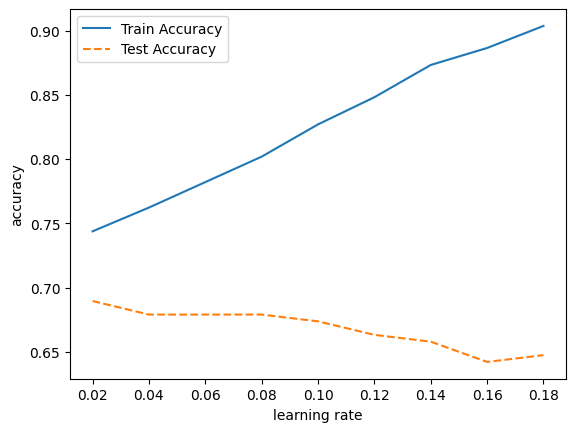

In [13]:
# LearningRate별 정확도 그래프 확인
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()

learning rate = 0.02

In [15]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators = v_n_estimators, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

# n_estimators별 정확도
df_accuracy_n.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.728,0.700
1,20,0.728,0.700
2,30,0.733,0.695
3,40,0.737,0.695
4,50,0.740,0.695
5,60,0.740,0.695
6,70,0.740,0.695
7,80,0.741,0.689
8,90,0.742,0.689
9,100,0.744,0.689


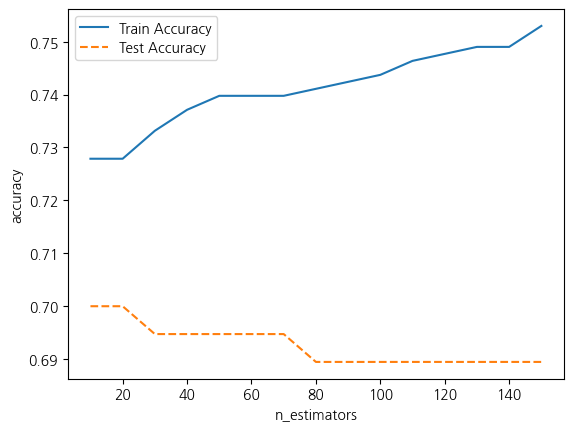

In [16]:
# 정확도를 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()